
## Dataset:
<a href="https://www.kaggle.com/archit9406/customer-transaction-dataset">Customer_transaction_dataset</a>

## Objective:
In this notebook, I will create user segmentation using RFM Analysis and cluster the segment by KMeans



In [1]:
#import library 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_excel('Raw_data.xlsx',sheet_name='Transactions')
df['transaction_date'].min()

Timestamp('2017-01-01 00:00:00')

In [3]:
#Check missing value

print(df.isnull().values.sum())
# Replace the ' 's with NaN
transaction_df = df.replace(" ",np.NaN)

1542


In [4]:
#Handling missing value with mean and mode for categorical value
print(df.dtypes)
print(df.isna().sum())

for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna(df[col].mode().iloc[0])
    else:
        df[col]=df[col].fillna(df[col].mean())
        
print(df.isna().sum())

transaction_id                      int64
product_id                          int64
customer_id                         int64
transaction_date           datetime64[ns]
online_order                      float64
order_status                       object
brand                              object
product_line                       object
product_class                      object
product_size                       object
list_price                        float64
standard_cost                     float64
product_first_sold_date           float64
dtype: object
transaction_id               0
product_id                   0
customer_id                  0
transaction_date             0
online_order               360
order_status                 0
brand                      197
product_line               197
product_class              197
product_size               197
list_price                   0
standard_cost              197
product_first_sold_date    197
dtype: int64
transaction_id          

# Exploratory Data Analysis

In [5]:
top_brand = df.groupby('brand').agg({'list_price':'sum',
                                     'transaction_id':'count'}).reset_index().rename(columns={'list_price':'total_sales','transaction_id':'qty_sold'})
sorted_sales_brand=top_brand.sort_values('total_sales',ascending=False).reset_index()
sorted_qty_brand=top_brand.sort_values('qty_sold',ascending=False).reset_index()

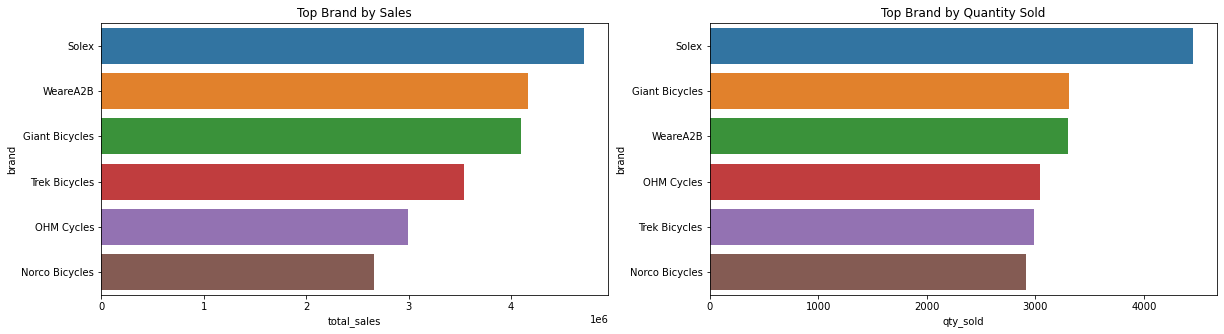

<Figure size 432x288 with 0 Axes>

In [6]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(ax=ax[0],x='total_sales',y='brand',data=sorted_sales_brand)
sns.barplot(ax=ax[1],x='qty_sold',y='brand',data=sorted_qty_brand)
ax[0].set_title('Top Brand by Sales')
ax[1].set_title('Top Brand by Quantity Sold')
plt.show()
plt.savefig('Top Brand by Sales and Quantity.png');

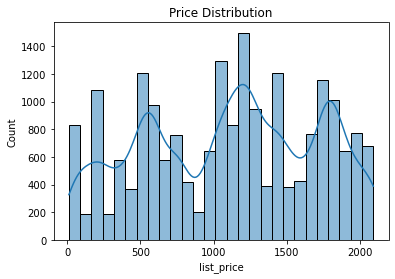

In [7]:
sns.histplot(x=df['list_price'],kde=True)
plt.title('Price Distribution');

In [8]:
df['Mon_Year'] = df['transaction_date'].dt.strftime('%b-%Y')
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Mon_Year
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,Feb-2017
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,May-2017
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,Oct-2017
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,Aug-2017
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,Oct-2017


In [9]:
trx=df.groupby('transaction_date')['transaction_id'].count().reset_index().rename(columns={'transaction_id':'total_trx'})

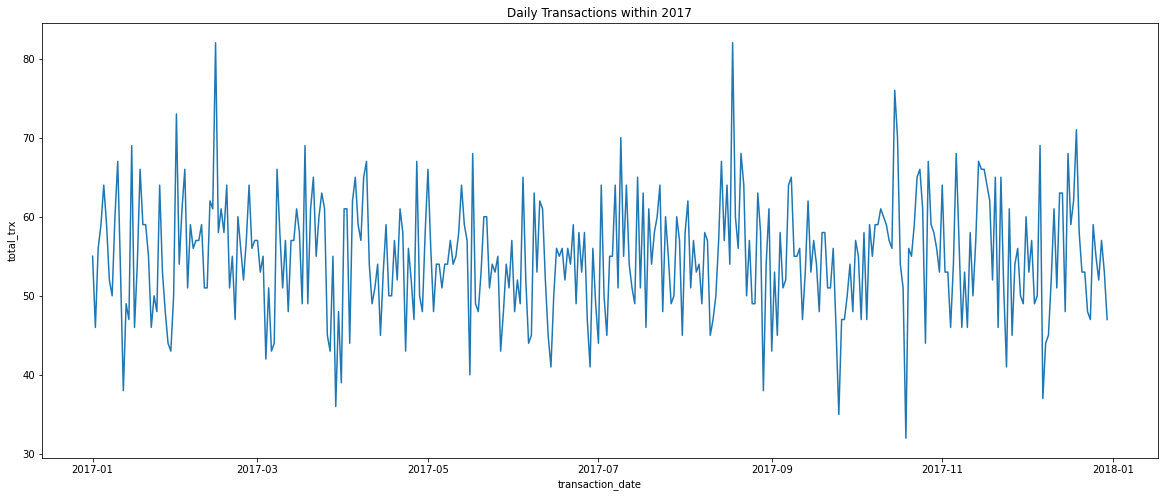

In [10]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
sns.lineplot(x='transaction_date',y='total_trx',data=trx,sort=True)
plt.title('Daily Transactions within 2017');


# RFM Analysis

In [11]:
snapshot_date = max(df['transaction_date'])
# Calculate Recency, Frequency and Monetary value for each customer 
data = df.groupby(['customer_id']).agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,
    'transaction_id': 'count',
    'list_price': 'sum'})

# Rename the columns 
data.rename(columns={'transaction_date': 'Recency',
                         'transaction_id': 'Frequency',
                         'list_price': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(data.head())

             Recency  Frequency  MonetaryValue
customer_id                                   
1                  7         11        9084.45
2                128          3        4149.07
3                102          8        9888.23
4                195          2        1047.72
5                 16          6        5903.20


In [12]:
# Store labels from 4 to 1 in a decreasing order
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
# Create a quartile with 4 groups and pass the previously created labels 
recency_quartiles = pd.qcut(data['Recency'], q=4, labels=r_labels)
frequency_quartiles = pd.qcut(data['Frequency'], q=4, labels=f_labels)
monetary_quartiles = pd.qcut(data['MonetaryValue'], q=4, labels=m_labels)



# Assign the quartile values to the Recency_Quartile column in `data`
data['R'] = recency_quartiles 
data['F'] = frequency_quartiles 
data['M'] = monetary_quartiles 


# Calculate RFM_Score
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)



# Print head
data.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
customer_id,,,,,,,
1,7,11,9084.45,4,4,4,12
2,128,3,4149.07,1,1,1,3
3,102,8,9888.23,1,4,4,9
4,195,2,1047.72,1,1,1,3
5,16,6,5903.20,4,2,2,8


# Data pre-processing for Clustering

In [16]:
#Normalized the data
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(data)

# Scale and center the data
data_normalized = scaler.transform(data)

# Create a pandas DataFrame
data_normalized = pd.DataFrame(data_normalized, index=data.index, columns=data.columns)

# Print summary statistics
print(data_normalized.describe().round(2))



       Recency  Frequency  MonetaryValue        R        F        M  RFM_Score
count  3494.00    3494.00        3494.00  3494.00  3494.00  3494.00    3494.00
mean      0.00      -0.00           0.00     0.00     0.00     0.00       0.00
std       1.00       1.00           1.00     1.00     1.00     1.00       1.00
min      -1.05      -2.03          -2.12    -1.35    -1.11    -1.34      -1.60
25%      -0.76      -0.74          -0.72    -0.46    -1.11    -1.12      -0.85
50%      -0.29       0.12          -0.11     0.43    -0.22     0.00      -0.10
75%       0.42       0.55           0.63     1.33     0.68     1.12       0.66
max       5.06       3.56           4.30     1.33     1.58     1.34       1.79


# KMeans Clustering
## Define number of clusters

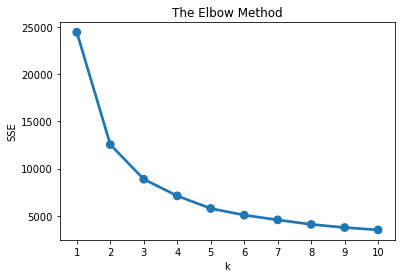

In [19]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

sse={}
# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
    
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   

# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [23]:
# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(data_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [39]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
data_cluster = data.assign(Cluster=cluster_labels)
data_cluster=data_cluster.reset_index()
# Group by cluster
data_cluster.groupby(['Cluster']).agg({'Recency': 'mean','Frequency': 'mean','MonetaryValue': 'mean'})

,Recency,Frequency,MonetaryValue
Cluster,,,
0,39.125828,8.214404,9461.431407
1,127.943548,3.771169,4098.414335
2,29.597372,4.896445,5148.031546


In [40]:
data_cluster['Segmentation']=np.where(data_cluster['Cluster']==0,'Loyal Customer',
                                      np.where(data_cluster['Cluster']==2,'Medium Customer','Potential to Loss'))

In [42]:
total_cust_segment=data_cluster.groupby('Segmentation')['customer_id'].count().reset_index()

Text(0, 0.5, 'Total Customers')

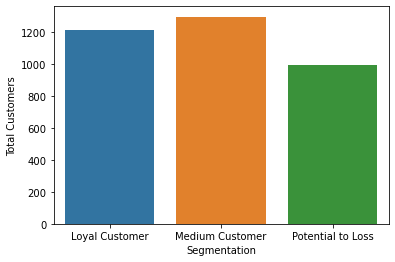

In [48]:
sns.barplot(data=total_cust_segment,x='Segmentation',y='customer_id');
plt.ylabel('Total Customers')